In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [3]:
!pip install rapidfuzz

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import tqdm
import json
import cv2
import os

from torch.nn            import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.utils.data    import Dataset, DataLoader
from torch.nn.functional import ctc_loss, log_softmax
from torchvision         import models

from string import digits, ascii_uppercase

from rapidfuzz.distance import Levenshtein

torch.manual_seed(911)
torch.cuda.manual_seed(911)
np.random.seed(911)

In [5]:
Levenshtein.distance("ac",'aa')

1

In [6]:
root_dir = "/kaggle/input/hw4dataset"
PATH_TO_TEST = os.path.join(root_dir, "test/result/")
PATH_TO_TRAIN_COMPLEX = os.path.join(root_dir,"train/train/complex/")
PATH_TO_TRAIN_SIMPLE = os.path.join(root_dir,"train/train/simple/")


In [7]:
def make_image_config():

    train_complex_images_dict = {}
    for file_name in os.listdir(PATH_TO_TRAIN_COMPLEX):
        if not os.path.isdir(file_name):

            train_complex_images_dict[PATH_TO_TRAIN_COMPLEX + file_name] = file_name.split('_')[2].split('.')[0]


    train_simple_images_dict = {}
    for file_name in os.listdir(PATH_TO_TRAIN_SIMPLE):
        if not os.path.isdir(file_name):

            train_simple_images_dict[PATH_TO_TRAIN_SIMPLE + file_name] = file_name.split('_')[2].split('.')[0]


    test_result_images_dict = {}
    for file_name in os.listdir(PATH_TO_TEST):
        if not os.path.isdir(file_name):

            test_result_images_dict[PATH_TO_TEST + file_name] = file_name.split('_')[0].split('.')[0]


    return train_complex_images_dict, train_simple_images_dict, test_result_images_dict


def union_dict_tr_te(train_complex_images_dict, train_simple_images_dict):
    train_images_dict = {}
    for key, elem in train_complex_images_dict.items():
        train_images_dict[key] = elem

    for key, elem in train_simple_images_dict.items():
        train_images_dict[key] = elem

    len(train_images_dict)

    return train_images_dict

In [8]:
train_complex_images_dict, train_simple_images_dict, test_result_images_dictt = make_image_config()

In [9]:
# test_result_images_dictt = {}
# for file_name in os.listdir(PATH_TO_TEST):
#         if not os.path.isdir(file_name):
#           test_result_images_dictt[PATH_TO_TEST + file_name] = file_name.split('_')[0].split('.')[0]
# test_result_images_dict = test_result_images_dictt

In [10]:
test_result_images_dict = list(test_result_images_dictt.items())

In [11]:
len(test_result_images_dict)

10518

In [12]:
train_images_dictt = union_dict_tr_te(train_complex_images_dict, train_simple_images_dict)

In [13]:
train_images_dict = list(train_images_dictt.items())

In [14]:
len(train_images_dict), len(train_complex_images_dict), len(train_simple_images_dict), len(test_result_images_dict)

(24547, 14221, 10326, 10518)

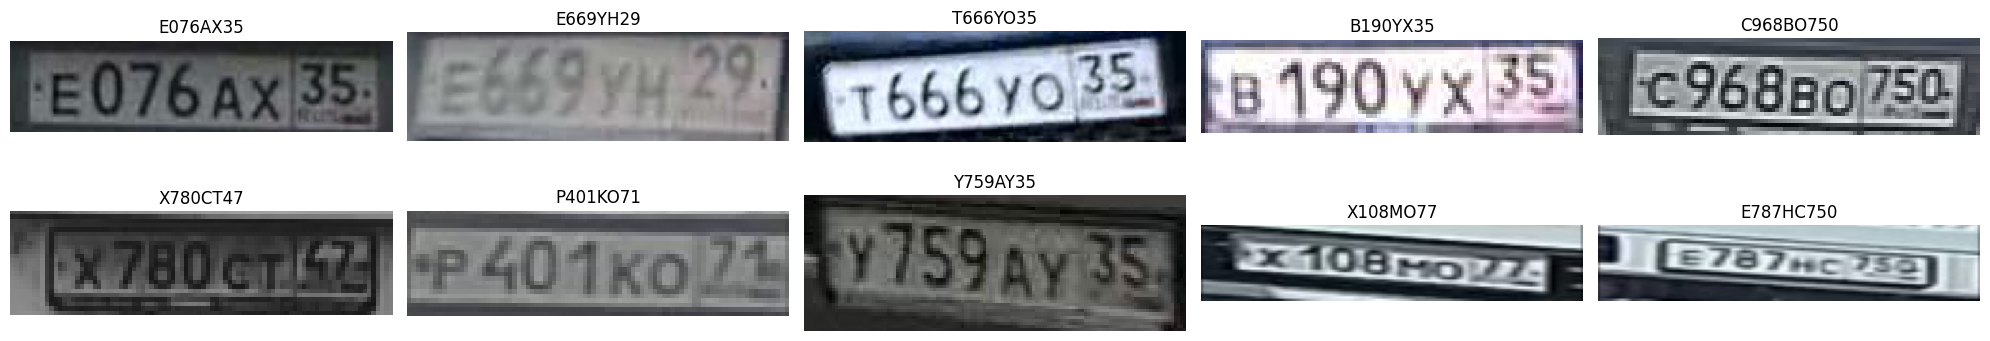

In [15]:
SAMPLE_SIZE = 10
NUM_COLS = 5
NUM_ROWS = 2

random_idxs = np.random.choice(len(train_images_dict), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for idx, item in enumerate(np.array(train_images_dict)[random_idxs], 1):
    text = item[1]
    image = cv2.imread(item[0])
    plt.subplot(NUM_ROWS, NUM_COLS, idx)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

In [17]:
print(ascii_uppercase)

ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [18]:
print(digits)

0123456789


In [19]:
def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.

    Args:
        - text: String of text.

    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D'
        or None if non-letter and non-digit character met in text.
    """
    mask = []

    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None

    return "".join(mask)

assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99") == "LDDDLLDD"
assert compute_mask("P@@@KA@@") is None

In [20]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.

    Args:
        - text: String of text.
        - alphabet: String of alphabet.

    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """

    for char in text:
        if char not in alphabet:
            return False

    return True

assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

In [21]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.

    Args:
        - config: List of dicts, each dict having keys "file" and "text".

    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item[1]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append(item)
    return config_filtered

In [22]:
config = filter_data(train_images_dict)
print("\nTotal items in data before filtering:", len(train_images_dict))
print("Total items in data after filtering:", len(config))

100%|██████████| 24547/24547 [00:00<00:00, 261305.70it/s]


Total items in data before filtering: 24547
Total items in data after filtering: 24547


In [23]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item[0]
            text = item[1]
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """

        seq = [self.alphabet.find(c) + 1 for c in text]

        return seq

In [24]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.

        Args:
            - item: Dict with keys "image", "seq", "seq_len", "text".

        Returns:
            Dict with image resized to self.size.
        """

        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)

        return item

In [25]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config=train_images_dict, alphabet=abc, transforms=transforms)

In [26]:
x = dataset[0]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


Image shape: (64, 320, 3)
Seq: [19, 5, 5, 7, 22, 11, 2, 6, 1] Seq_len: 9
Text: C446XA150


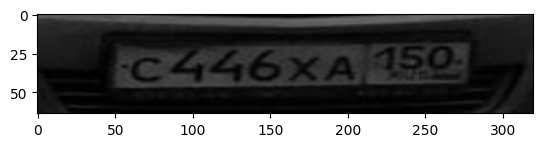

In [27]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

In [28]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [29]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [30]:
print("Image:"  , batch["image"  ].size())
print("Seq:"    , batch["seq"    ].size())
print("Seq:"    , batch["seq"    ])
print("Seq_len:", batch["seq_len"])
print("Text:"   , batch["text"   ])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([35])
Seq: tensor([19,  5,  5,  7, 22, 11,  2,  6,  1, 21,  2,  7,  8, 11, 15,  2, 10,  8,
        11,  6,  9,  2, 20, 16,  2,  6,  1, 11, 10,  9,  1, 18, 18, 10,  9],
       dtype=torch.int32)
Seq_len: tensor([9, 9, 9, 8], dtype=torch.int32)
Text: ['C446XA150', 'Y167AM197', 'A581TH150', 'A980PP98']


# Строим модель

In [31]:
class FeatureExtractor(Module):

    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()

        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])

        self.pool = AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn2.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.

        Args:
            - x: Tensor of features (shaped B x C x H x W).

        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()

        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)

        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)

        return features

In [32]:
feature_extractor = FeatureExtractor()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s] 


In [33]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 20)

In [34]:
class SequencePredictor(Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()

        self.num_classes = num_classes
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)

        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)

    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.

        Args:
            - batch_size: Int size of batch

        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1

        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)

        return h

    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.

        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).

        Returns:
            New tensor shaped (W x B x H).
        """

        x = x.squeeze(1)
        x = x.permute(2, 0, 1)

        return x

    def forward(self, x):
        x = self._reshape_features(x)

        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)

        x = self.fc(x)
        return x

In [35]:
sequence_predictor = SequencePredictor(input_size=512,
                                       hidden_size=128,
                                       num_layers=8,
                                       num_classes=len(abc) + 1,
                                       dropout=0.3, 
                                       bidirectional=False)

In [36]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 512)

In [37]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 23)

In [38]:
class CRNN(Module):

    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=8, rnn_dropout=0.2, rnn_bidirectional=True):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, output_len=cnn_output_len
        )
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
            num_classes=len(alphabet)+1, dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [39]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [40]:
crnn = CRNN()

In [41]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, 23)

In [42]:
decode(y, abc)

['X7X78']

# Обучение

In [43]:
ACTUALLY_TRAIN = True

In [44]:
crnn = CRNN()

In [45]:
num_epochs = 30
batch_size = 32
num_workers = 2

In [46]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);
device

device(type='cuda', index=0)

In [47]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [48]:
np.random.shuffle(config)
train_size = int(len(config) * 1.0)
config_train = config[:train_size]
config_val   = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset   = RecognitionDataset(config_val  , transforms=Resize())

In [49]:
test_dataset = RecognitionDataset(test_result_images_dict  , transforms=Resize())

In [50]:
len(train_dataset), len(val_dataset)

(24547, 0)

In [51]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True,
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn)

In [52]:
# batch = next(iter(train_dataloader))
# batch

In [53]:
len(train_dataloader)

767

In [54]:
crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt,  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        torch.save(crnn.state_dict(), f = "/kaggle/working/model.pth")
        print(i, np.mean(epoch_losses))
else:
    # image_train_log = cv2.imread("./resources/train_log.png")
    # plt.figure(figsize=(15, 20))
    # plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    # plt.axis("off")
    # plt.show()
    with open(root_dir+"/kaggle/working/model.pth", "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
#     with open(root_dir+"crnn.pth.tar", "rb") as fp:
#         state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

100%|██████████| 767/767 [01:09<00:00, 11.11it/s]


0 2.4607017717896102


100%|██████████| 767/767 [00:47<00:00, 16.20it/s]


1 1.9541404317224196


100%|██████████| 767/767 [00:48<00:00, 15.79it/s]


2 1.4629908800125122


100%|██████████| 767/767 [00:48<00:00, 15.77it/s]


3 1.175689826033417


100%|██████████| 767/767 [01:00<00:00, 12.72it/s]


4 0.9413200072079625


100%|██████████| 767/767 [00:49<00:00, 15.38it/s]


5 0.6546556481404285


100%|██████████| 767/767 [00:48<00:00, 15.87it/s]


6 0.49275458329193284


100%|██████████| 767/767 [00:48<00:00, 15.74it/s]


7 0.3979380553517845


100%|██████████| 767/767 [00:49<00:00, 15.44it/s]


8 0.33219521517004463


100%|██████████| 767/767 [00:55<00:00, 13.76it/s]


9 0.24737602992971686


100%|██████████| 767/767 [00:52<00:00, 14.53it/s]


10 0.16387317189764636


100%|██████████| 767/767 [00:52<00:00, 14.65it/s]


11 0.13000455452068532


100%|██████████| 767/767 [00:48<00:00, 15.78it/s]


12 0.11911728400421345


100%|██████████| 767/767 [00:48<00:00, 15.84it/s]


13 0.09838697773002505


100%|██████████| 767/767 [00:48<00:00, 15.81it/s]


14 0.08230903981110224


100%|██████████| 767/767 [00:52<00:00, 14.73it/s]


15 0.07563203733142422


100%|██████████| 767/767 [00:57<00:00, 13.45it/s]


16 0.07324910441090533


100%|██████████| 767/767 [01:13<00:00, 10.48it/s]


17 0.06352926153359349


100%|██████████| 767/767 [01:10<00:00, 10.90it/s]


18 0.06343005552543073


100%|██████████| 767/767 [00:48<00:00, 15.80it/s]


19 0.057753880592026643


100%|██████████| 767/767 [00:48<00:00, 15.72it/s]


20 0.05649146197043175


100%|██████████| 767/767 [00:48<00:00, 15.70it/s]


21 0.04827406263158619


100%|██████████| 767/767 [00:48<00:00, 15.79it/s]


22 0.04916455729219776


100%|██████████| 767/767 [00:49<00:00, 15.61it/s]


23 0.04401492326055329


100%|██████████| 767/767 [00:49<00:00, 15.64it/s]


24 0.04618115352121858


100%|██████████| 767/767 [00:48<00:00, 15.75it/s]


25 0.04046965283833473


100%|██████████| 767/767 [00:50<00:00, 15.05it/s]


26 0.04206772465404546


100%|██████████| 767/767 [00:50<00:00, 15.24it/s]


27 0.035538841111189656


100%|██████████| 767/767 [00:49<00:00, 15.49it/s]


28 0.0358040355336567


100%|██████████| 767/767 [00:48<00:00, 15.69it/s]


29 0.03267477928919443


In [55]:
torch.save(crnn.state_dict(), f = "/kaggle/working/model.pth")

In [56]:
errors=[]
def calc_levenshtein(texts_pred,texts):
    sum = 0
    # print(len(texts))
    for i in range(len(texts)):
        sum+=Levenshtein.distance(texts[i], texts_pred[i])
        if(texts[i]!=texts_pred[i]):
            errors.append([texts[i],texts_pred[i] ])
        # print(texts[i], texts_pred[i], sum)
    return sum / len(texts)

In [ ]:
crnn.eval()
if ACTUALLY_TRAIN:
    val_losses = []
    levenshtein_metric=[]
    for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]
        texts = b["text"]

        with torch.no_grad():
            # seqs_pred = crnn(images).cpu()
            preds = crnn(images.to(device)).cpu().detach()
        # preds = crnn(images.to(device)).cpu().detach()
        texts_pred = decode(preds, crnn.alphabet)
        # print(calc_levenshtein(texts_pred, texts))
        levenshtein_metric.append(calc_levenshtein(texts_pred, texts))
        log_probs = log_softmax(preds, dim=2)
        seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        val_losses.append(loss.item())
    print("\nlevenshtein_metric= ", np.mean(levenshtein_metric))
    print("loss= ",np.mean(val_losses))
else:
  pass
    # image_val_log = cv2.imread("./resources/val_log.png")
    # plt.figure(figsize=(15, 20))
    # plt.imshow(image_val_log[:, :, ::-1], interpolation="bilinear")
    # plt.axis("off")
    # plt.show()

In [58]:
print(errors)

[]


In [59]:
len(errors)

0

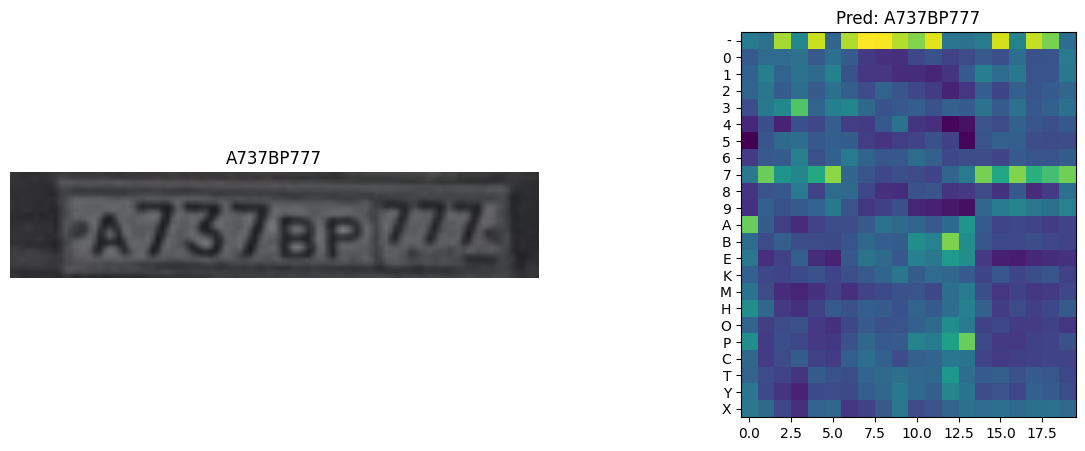

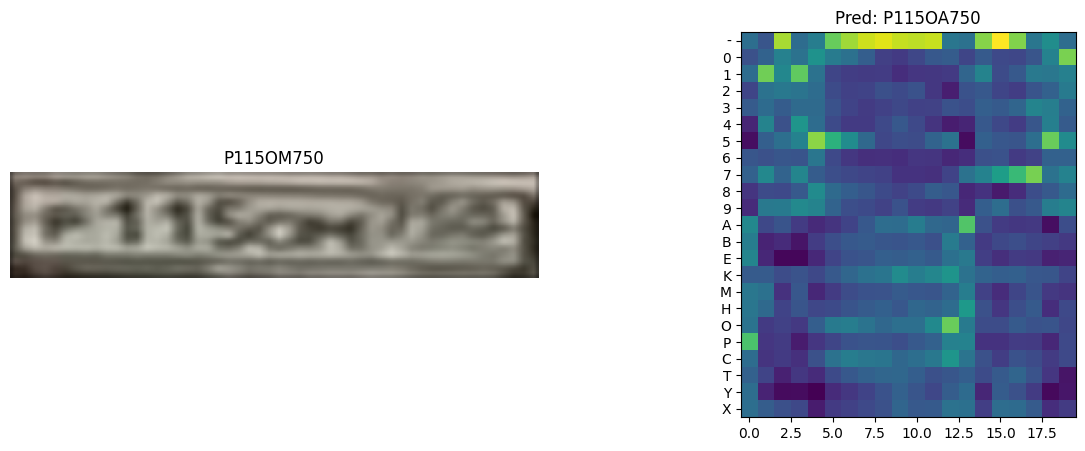

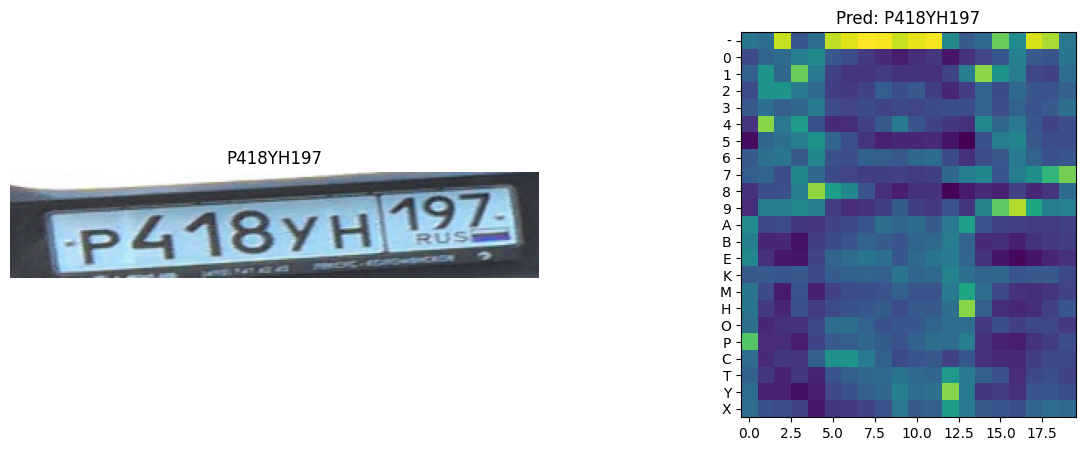

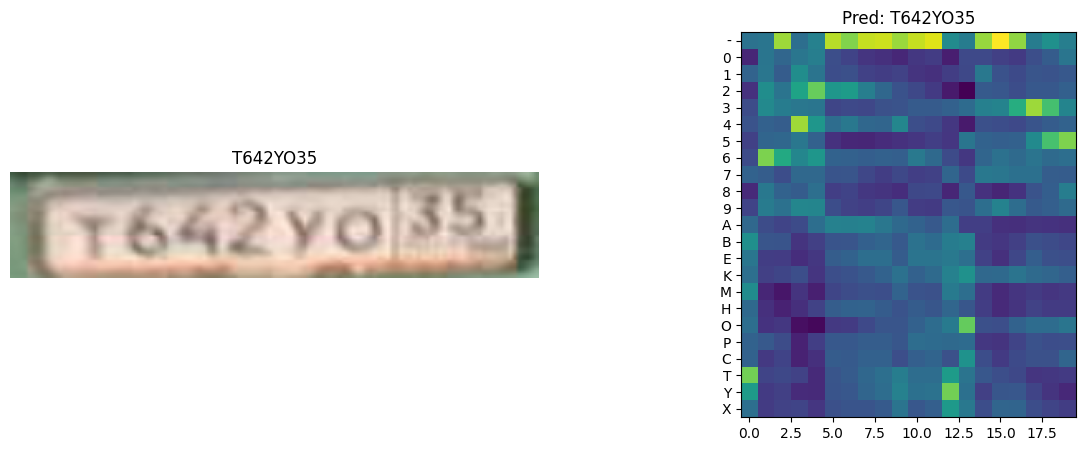

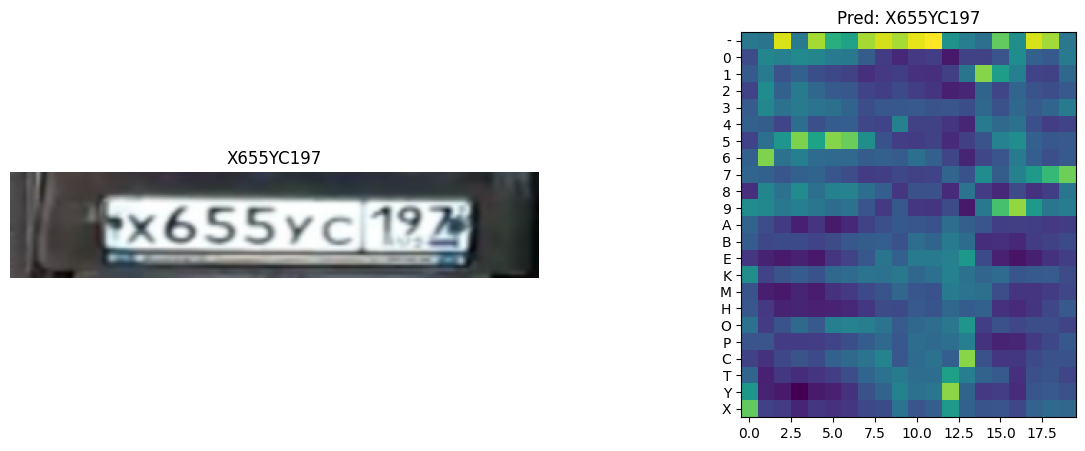

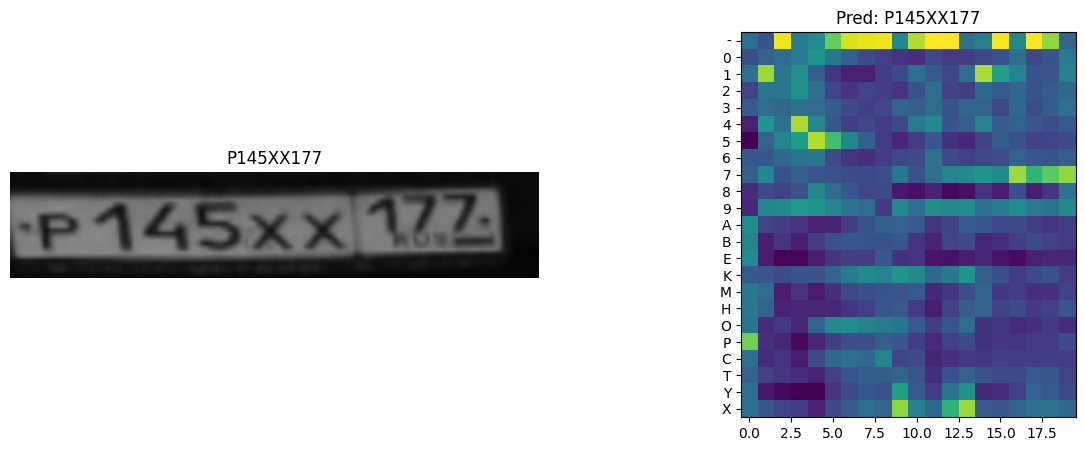

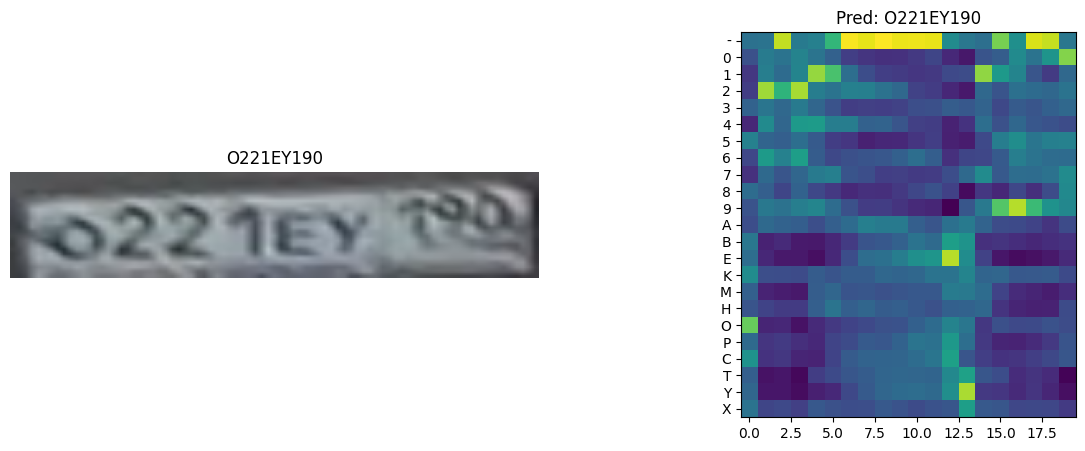

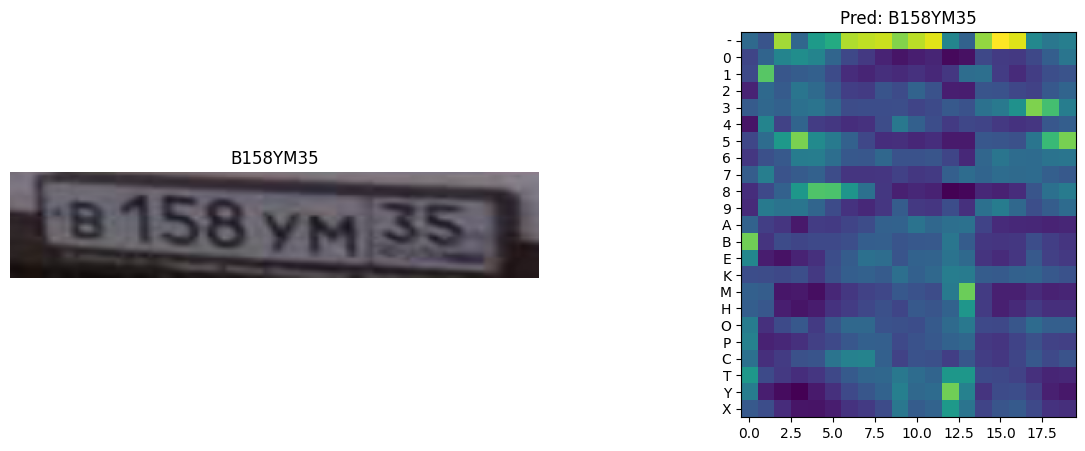

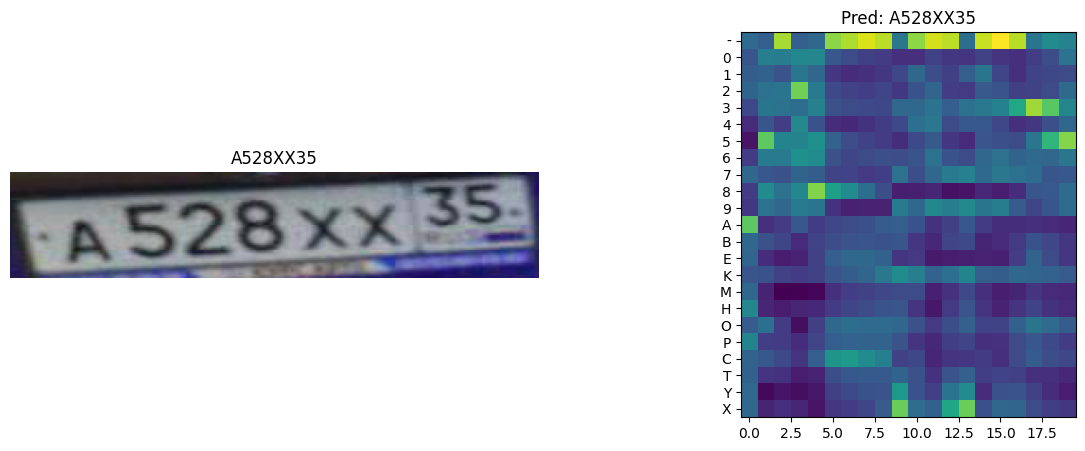

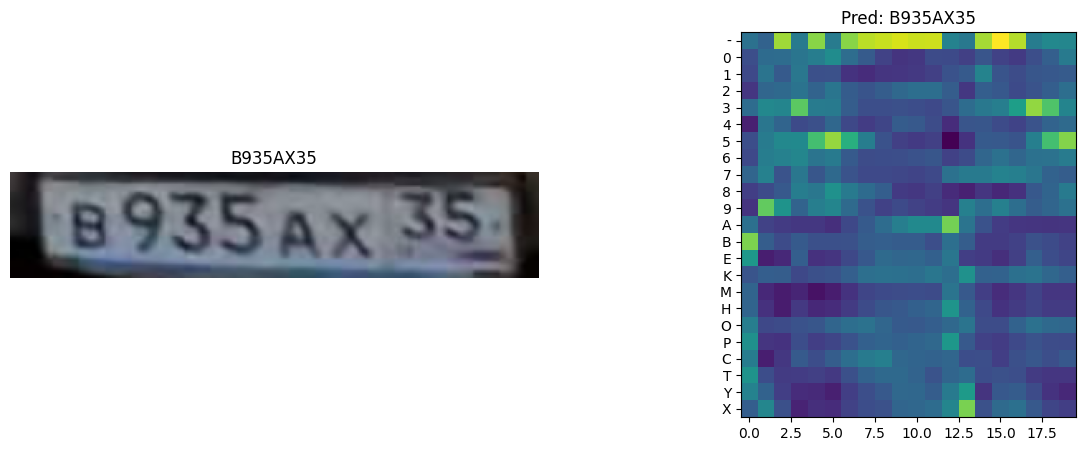

In [60]:
if ACTUALLY_TRAIN:
    y_ticks = ["-"] + [x for x in abc]

    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]

    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)
    for i in range(10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T

        plt.subplot(1, 2, 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.title(texts[i])

        plt.subplot(1, 2, 2)
        plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
        plt.title("Pred: "+ texts_pred[i])

        plt.show()
else:
    for i in range(1, 11):

        image_val_log = cv2.imread(f"{PATH_TO_TEST }{str(i)}.png")
        print(f"{PATH_TO_TEST }{str(i)}.png")
        plt.figure(figsize=(15, 8))
        plt.imshow(image_val_log[:, :, ::-1], interpolation="none")
        plt.axis("off")
        plt.show()

#TEST

In [61]:

test_dataset = RecognitionDataset(test_result_images_dict  , transforms=Resize())

In [62]:
test_dataloader = DataLoader(test_dataset,
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn)

In [63]:
crnn.eval()
test_losses = []
test_levenshtein_metric=[]
preds_d = {}
for i, b in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]
        indexes = b["text"]
        with torch.no_grad():
            preds = crnn(images.to(device)).cpu().detach()
            
        texts_pred = decode(preds, crnn.alphabet)
        for i in range(len(indexes)):
            preds_d[indexes[i]] = texts_pred[i]
        
        # print(calc_levenshtein(texts_pred, texts))
#         predss.append(texts_pred)
print("\nlens= ", len(preds_d))
# print("\ntexts_pred= ", texts_pred)
# print("predss= ",predss)

100%|██████████| 329/329 [00:33<00:00,  9.83it/s]


lens=  10518


In [64]:
import pandas as pd
d = {'indexx': preds_d.keys(), 'label': preds_d.values()}
df = pd.DataFrame(data=d)
df.indexx = df.indexx.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10518 entries, 0 to 10517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   indexx  10518 non-null  int64 
 1   label   10518 non-null  object
dtypes: int64(1), object(1)
memory usage: 164.5+ KB


In [65]:
df = df.sort_values(by='indexx',ignore_index=True)
df

,indexx,label
0,0,A904CC35
1,1,B581YY35
2,2,A481CC35
3,3,B161EP35
4,4,A725XO35
...,...,...
10513,10513,C243TP77
10514,10514,H750OB71
10515,10515,A737XO35
10516,10516,T635KP77


In [66]:
df.label

0         A904CC35
1         B581YY35
2         A481CC35
3         B161EP35
4         A725XO35
           ...    
10513     C243TP77
10514     H750OB71
10515     A737XO35
10516     T635KP77
10517    E475EY750
Name: label, Length: 10518, dtype: object

In [67]:

df_sub = pd.read_csv(root_dir+"/submission.csv")
df_sub

,index,label
0,0,C3COX96B
1,1,6C128YMP
2,2,7XO4M8OM
3,3,KY3377BC
4,4,PB7MHAM8
...,...,...
10513,10513,9Y0ATPTB
10514,10514,XY83BHPC
10515,10515,BT0TE7CT
10516,10516,MH6EY8KY


In [68]:
df_sub.label=df.label
df_sub

,index,label
0,0,A904CC35
1,1,B581YY35
2,2,A481CC35
3,3,B161EP35
4,4,A725XO35
...,...,...
10513,10513,C243TP77
10514,10514,H750OB71
10515,10515,A737XO35
10516,10516,T635KP77


In [69]:
df_sub.to_csv('my_submission.csv', index=False)